In [1]:
# Imports
import numpy as np
from math import pi
%load_ext cython
%matplotlib notebook

We want to generate synthetic $\mathcal{H}$ matrices with a special function. Right now it is done with a formula:
$$A_{ij} = \sum_{k=0}^{N-1} S[k]*e^{\frac{2\pi I}{N}(i\ mod\ N)}*e^{\frac{2\pi I}{N}(j\ mod\ N)},$$
where $I$ is a complex square root of -1, $N$ is a size of a block (not of a matrix).

In [2]:
%%cython -a
import numpy as np
cimport numpy as cnp
cdef extern from 'complex.h':
    double complex cexp(double complex)
from libc.math cimport sqrt
from math import pi
cdef double PI=pi
cimport cython

#@cython.boundscheck(False)
#@cython.cdivision(True)
def fourier_generator(int block_size, double [:] S, long[:] i, long[:] j,
                      double complex[:,:,:] angle_row, double complex[:,:,:] angle_col):
    cdef long N = i.shape[0], M = j.shape[0], K = S.shape[0]
    result = np.zeros((N, M), dtype=np.complex128)
    cdef double complex[:,:] view = result
    cdef double complex s, w = PI*2.j/block_size
    cdef long ii, jj, tt, k, ti, tj, block_i, block_j
    cdef double complex tmp_i, tmp_j
    for ii in range(N):
        ti = i[ii] % block_size
        block_i = i[ii] / block_size
        for jj in range(M):
            tj = j[jj] % block_size
            block_j = j[jj] / block_size
            for kk in range(K):
                tmp_i = 0.
                tmp_j = 0.
                for tt in range(block_size):
                    tmp_i += cexp(w*ti*tt)*angle_col[block_j, tt, kk]
                    tmp_j += cexp(w*tj*tt)*angle_row[block_i, tt, kk]
                view[ii, jj] += S[kk]/block_size*tmp_i*tmp_j
    return result

def fourier_generator_norot(int block_size, double complex[:] S, long[:] i, long[:] j):
    cdef long N = i.shape[0], M = j.shape[0], K = S.shape[0]
    result = np.zeros((N, M), dtype=np.complex)
    cdef double complex[:,:] view = result
    cdef double complex s, w = PI*2.j/block_size
    cdef long ii, jj, k, ti, t
    for k in range(K):
        s = S[k]/block_size
        for ii in range(N):
            ti = i[ii] % block_size
            for jj in range(M):
                t = ti+j[jj] % block_size
                view[ii, jj] += s*cexp(w*t*k)
    return result

In [3]:
block_size = 10
block_count = 10
N = block_size*block_count
S = np.array([1., 1e-1, 1e-2, 1e-3], dtype=np.double)
row = np.arange(N)
col = row
angle_row = np.array([np.linalg.qr(np.random.randn(block_size, block_size, 2).view(np.complex128)[:,:,0])[0]
                      for i in range(block_count)])
angle_col = np.array([np.linalg.qr(np.random.randn(block_size, block_size, 2).view(np.complex128)[:,:,0])[0]
                      for i in range(block_count)])
A = fourier_generator(block_size, S, row, col, angle_row, angle_col)

In [4]:
test = np.zeros((block_count, block_count))
norm_S = np.linalg.norm(S)
long_S = np.zeros(block_size)
long_S[:S.size] = S
for i in range(block_count):
    for j in range(block_count):
        s = np.linalg.svd(A[block_size*i:block_size*(i+1),block_size*j:block_size*(j+1)])[1]
        test[i, j] = np.linalg.norm(s-long_S)/norm_S

<IPython.core.display.Javascript object>


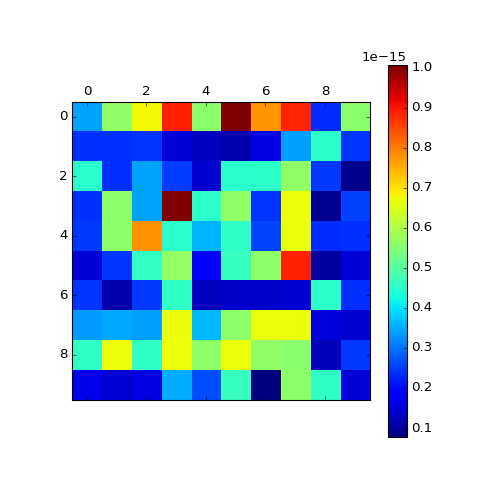

In [8]:
import matplotlib.pyplot as plt
plt.matshow(test)
plt.colorbar()